# 1. import libariers and data 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy.stats import skew
from scipy.special import boxcox1p

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge,LogisticRegression

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error ,r2_score 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("Spectral")

In [2]:
train = pd.read_csv(r"C:\Users\tawfi\OneDrive\سطح المكتب\kaggle\house-prices-advanced-regression-techniques\train.csv")
test = pd.read_csv(r"C:\Users\tawfi\OneDrive\سطح المكتب\kaggle\house-prices-advanced-regression-techniques\test.csv")

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the 'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# concatenate the two dataframes

ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values

# concatenate the two dataframes
df = pd.concat((train, test)).reset_index(drop=True)
df.drop(['SalePrice'], axis=1, inplace=True)

# 2. data review & understanding data

In [3]:
# Get the number of columns of each data type
print(df.dtypes)
print(f"""\n
Number of float features: {len(df.select_dtypes('float').columns)}
Number of int features: {len(df.select_dtypes('int').columns)}
Number of object features: {len(df.select_dtypes('object').columns)}

""")  

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object


Number of float features: 11
Number of int features: 25
Number of object features: 43




In [4]:
df.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal


In [5]:
# check about duplicated rows
print(f"\n there are {df.duplicated().sum()} duplicated rows")
    


 there are 2 duplicated rows


In [6]:
# check about missing values

print(f"all missing values in data {df.isna().sum().sum()}")

all missing values in data 13965


In [7]:
# columns which have nulls and the percentage of nulls in each column

train_data_na = (df.isnull().sum() / len(df)) 
train_data_na = train_data_na.drop(train_data_na[train_data_na == 0].index).sort_values(ascending=False)
train_missing_data = pd.DataFrame({'mean of nulls' :train_data_na , "number_of_nulls" : df[train_data_na.index].isna().sum()})
train_missing_data

,mean of nulls,number_of_nulls
PoolQC,0.996574,2909
MiscFeature,0.964029,2814
Alley,0.932169,2721
Fence,0.804385,2348
FireplaceQu,0.486468,1420
LotFrontage,0.166495,486
GarageFinish,0.054471,159
GarageQual,0.054471,159
GarageCond,0.054471,159
GarageYrBlt,0.054471,159


there are many missing data and two duplicated rows. let's handle them.

# 3. clean data

### deal with missing values

missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis.
as you see we have alot of null values and it will affect on model's performance.
so let's deal with missing values .

put in your mind that : A general rule is that, if more than half of the data in a column is missing, it's better to drop it then try imputing.

so if percentage of missing values in any column is bigger than 0.5 . it will be dropped.

* FireplaceQu column


In [8]:
df[df["Fireplaces"]==0][["FireplaceQu"]].isna().sum()

FireplaceQu    1420
dtype: int64

shit!! all nulls values in FireplaceQu column expresse zero of the number of fire places. data description says NA means "no fireplace"


* LotFrontage column


Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood so we can fill in missing values by the median LotFrontage of the neighborhood.


In [9]:
# handle columns 
df["FireplaceQu"] = df["FireplaceQu"].fillna("Nofireplaces")
df["LotFrontage"] = df.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* impute other columns with mean , median or mode and drop.

In [10]:
def deal_with_nulls_and_duplicates( dataframe , drop_na = False ):
    
    # handle with missing data 
    if drop_na is True:
        dataframe.dropna(inplace=True)
    
    else:
        for col in dataframe.columns:
        
            # drop columns that are more than half nan-values.
            if dataframe[col].isna().sum()/len(dataframe) > 0.5 :
                dataframe.drop(columns=col , inplace = True)
        
            # fill nulls .
            elif dataframe[col].dtype =="float":
                dataframe[col] = dataframe[col].fillna(dataframe[col].mean())
            
            elif dataframe[col].dtype =="int":
                dataframe[col] = dataframe[col].fillna(dataframe[col].median())
            
            elif dataframe[col].dtype =="object":
                dataframe[col] = dataframe[col].fillna(dataframe[col].mode()[0])
            
    # remove duplicated rows.
    dataframe.drop_duplicates(inplace=True)
    
    return dataframe.head()

In [11]:
deal_with_nulls_and_duplicates(df)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


### low or high cardinality


In [12]:
for col in df.select_dtypes("O").columns:
    print("\n" + 5* "-" + col .center(20) + 5 * "-"+"\n")
    print(f"* the number unique values equal {df[col].nunique()} \n")
    print(df[col].value_counts())


-----      MSZoning      -----

* the number unique values equal 5 

RL         2269
RM          459
FV          138
RH           26
C (all)      25
Name: MSZoning, dtype: int64

-----       Street       -----

* the number unique values equal 2 

Pave    2905
Grvl      12
Name: Street, dtype: int64

-----      LotShape      -----

* the number unique values equal 4 

Reg    1857
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

-----    LandContour     -----

* the number unique values equal 4 

Lvl    2620
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

-----     Utilities      -----

* the number unique values equal 2 

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

-----     LotConfig      -----

* the number unique values equal 5 

Inside     2131
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

-----     LandSlope      -----

* the number unique values equal 3 

Gtl    2776
Mod     1

* look at `Street` column . 2905 records are `Pave` but just 12 records are `Grvl`.
* also `Utilities` column . all records are `AllPub` , except for one `NoSeWa` .

this features won't help in predictive modelling. We can then safely remove it.

In [13]:
# drop categorical columns with low or high cardinality
df.drop(columns=['Street','Utilities','MSSubClass'], inplace=True)

### feature engineering

let's engine some feature 

* create `'TotalSF'` feature , Total Square Feet feature , by adding the values of `'TotalBsmtSF'` ,`'1stFlrSF'` and `'2ndFlrSF'` columns .


In [14]:
#Adding Total Square Feet feature 
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

year columns

In [15]:
year_cols=[f for f in df.columns if "Year" in f or "Yr" in f]
df[year_cols].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


* create `'HouseAge'` feature , house age when it was sold ,  by subtract the values of `'YrSold'` and `'YearBuilt'`columns.
* create `'AgeRemod'` feature , age of renovated house when it was sold ,  by subtract the values of `'YrSold'` and`'YearRemodAdd'` columns.
* create `'AgeGrgSold'` feature , age of garage when it was sold , by subtract the values of `'YrSold'` and `'GarageYrBlt'` columns.


In [16]:
#House age when it was sold
df['HouseAge'] = df['YrSold']-df['YearBuilt']
#age of renovated house when it was sold
df['AgeRemod'] = df['YrSold']-df['YearRemodAdd']
#age of garage when it was sold
df['AgeGrgSold'] = df['YrSold']-df['GarageYrBlt']

basement columns

In [17]:
basement_cols=[f for f in df.columns if "Bsmt" in f]
df[basement_cols].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,1.0,0.0
1,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,0.0,1.0
2,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,1.0,0.0
3,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,1.0,0.0
4,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,1.0,0.0


create `TotalBsmtSF` feature , Total Basement Area , by adding the values of `BsmtFinSF1` , `BsmtFinSF2` and `BsmtUnfSF` columns

In [18]:
# Total Basement Area
df["TotalBsmtSF"] = df['BsmtFinSF1']+df['BsmtFinSF2']+df['BsmtUnfSF']

drop columns:

`BsmtFinSF1` , `BsmtFinSF2` , `BsmtUnfSF` , `YrSold` , `YearBuilt` , `GarageYrBlt` , `YearRemodAdd` , `TotalBsmtSF` , `1stFlrSF` and `2ndFlrSF`

In [19]:
# drop leaky columns
df.drop(columns=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF' ,'YrSold',
                     'YearBuilt','GarageYrBlt','YearRemodAdd' ,
                     'TotalBsmtSF' ,'1stFlrSF','2ndFlrSF'], inplace=True)

In [20]:
df.shape

(2917, 66)

# 4. explore data

### 4.1. explore numerical features

In [21]:
#  explore porch columns

porch_cols=[f for f in df.columns if "Porch" in f]
df[porch_cols].describe([0.8,0.84,0.9])

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
count,2917.000000,2917.000000,2917.000000,2917.000000
mean,47.448749,23.114158,2.604045,16.073363
std,67.562874,64.263424,25.196714,56.202054
min,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000
80%,85.000000,0.000000,0.000000,0.000000
84%,101.000000,0.000000,0.000000,0.000000
90%,131.000000,112.000000,0.000000,0.000000
max,742.000000,1012.000000,508.000000,576.000000


as you see above 84% of 3SsnPorch , EnclosedPorch and ScreenPorch is equal zero . This will cause skewness data that reduce performane our model.
so will drop them

In [22]:
df[["LowQualFinSF","MiscVal"]].describe([0.85,0.9,0.95])

,LowQualFinSF,MiscVal
count,2917.000000,2917.000000
mean,4.670209,50.860816
std,46.391690,567.595198
min,0.000000,0.000000
50%,0.000000,0.000000
85%,0.000000,0.000000
90%,0.000000,0.000000
95%,0.000000,0.000000
max,1064.000000,17000.000000


shit!! also LowQualFinSF and MiscVal columns . above 95% of its values equal zero . we will drop it

In [23]:
# drop columns
df.drop(columns=['3SsnPorch', 'EnclosedPorch' ,'ScreenPorch'] , inplace=True)
df.drop(columns=['LowQualFinSF',"MiscVal"] , inplace=True)

In [24]:
descrete_cols = [col for col in df.columns if df[col].nunique() < 15 and df[col].dtypes != 'O']

# numerical columns
num_cols = [col for col in df.columns if df[col].dtypes != 'O']
num_cols = [col for col in num_cols if col not in descrete_cols]

print(f'number of numerical columns: {len(num_cols)}')
print(f'num_cols: {num_cols}')
print('------------------------')
print(f'number of descrete columns: {len(descrete_cols)}')
print(f'descrete columns: {descrete_cols}')

number of numerical columns: 11
num_cols: ['LotFrontage', 'LotArea', 'MasVnrArea', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'TotalSF', 'HouseAge', 'AgeRemod', 'AgeGrgSold']
------------------------
number of descrete columns: 13
descrete columns: ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold']


In [25]:
for col in num_cols:
    print(f"{col}   {df[col].nunique()}") 

LotFrontage   130
LotArea   1951
MasVnrArea   445
GrLivArea   1292
GarageArea   604
WoodDeckSF   379
OpenPorchSF   252
TotalSF   1499
HouseAge   128
AgeRemod   63
AgeGrgSold   116


In [26]:
def two_plots_num_column(feature):
    
    print(f"the skewness value of {feature} column = {df[feature].skew():.2f}")
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('histgram')
    sns.histplot(data=df, x=feature, kde=True)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    plt.subplot(1,2,2)
    plt.title('Boxplot')
    sns.boxplot(y=df[feature])

the skewness value of LotFrontage column = 1.51
the skewness value of LotArea column = 12.84
the skewness value of MasVnrArea column = 2.61
the skewness value of GrLivArea column = 1.27
the skewness value of GarageArea column = 0.24
the skewness value of WoodDeckSF column = 1.84
the skewness value of OpenPorchSF column = 2.54
the skewness value of TotalSF column = 1.52
the skewness value of HouseAge column = 0.60
the skewness value of AgeRemod column = 0.45
the skewness value of AgeGrgSold column = 0.39


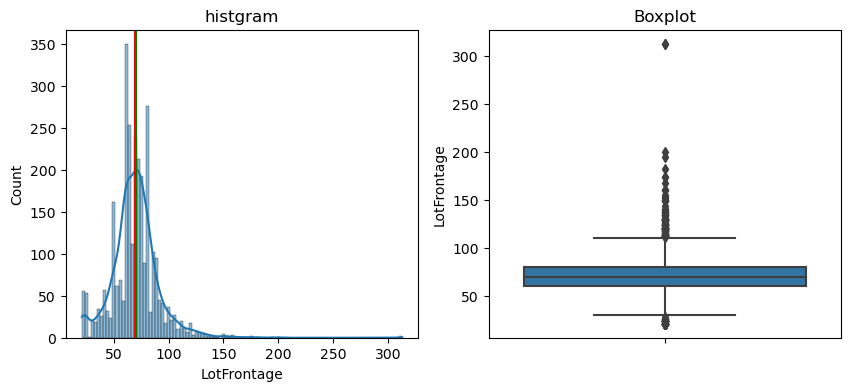

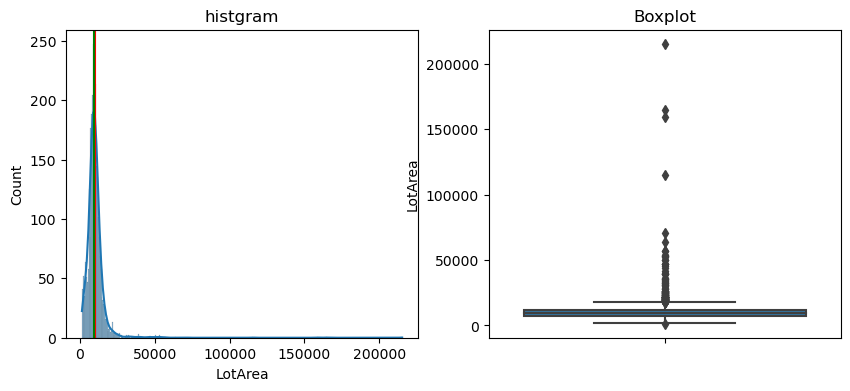

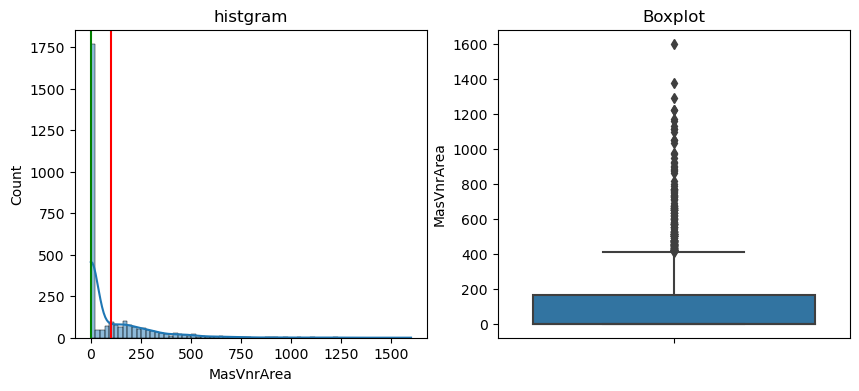

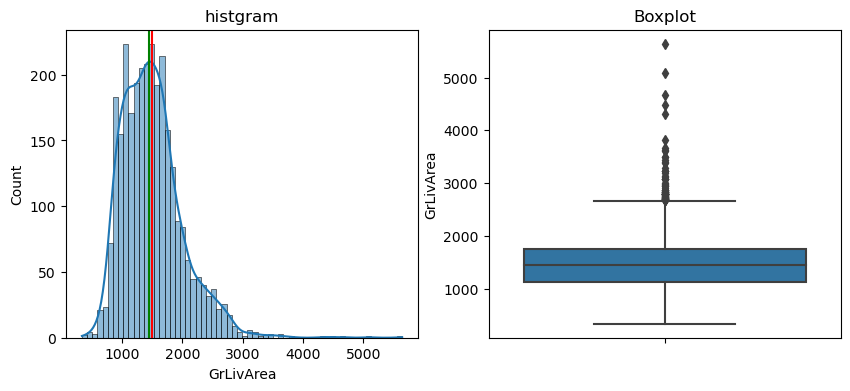

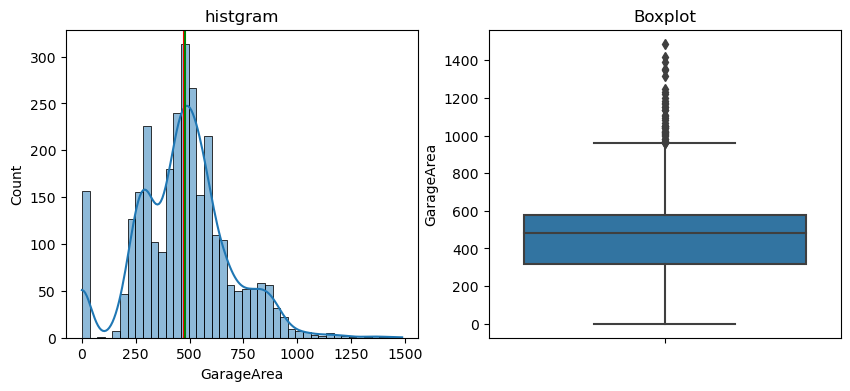

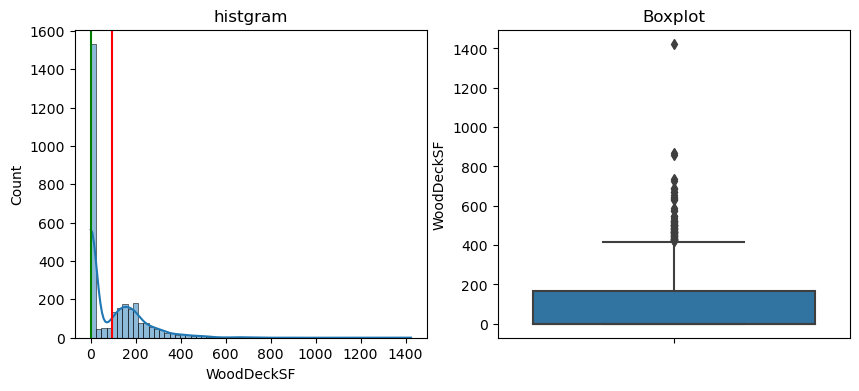

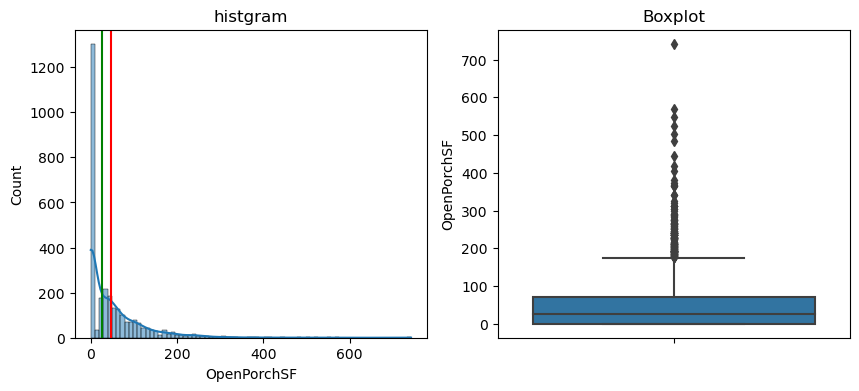

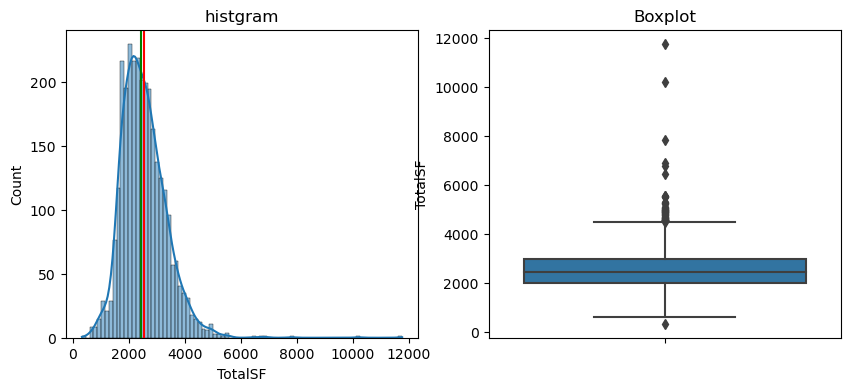

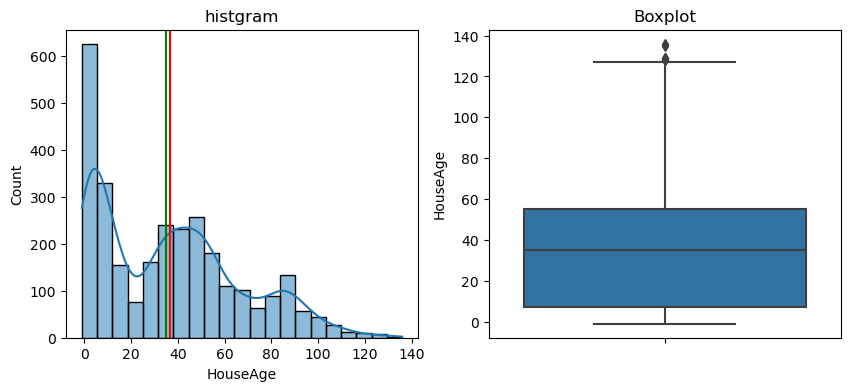

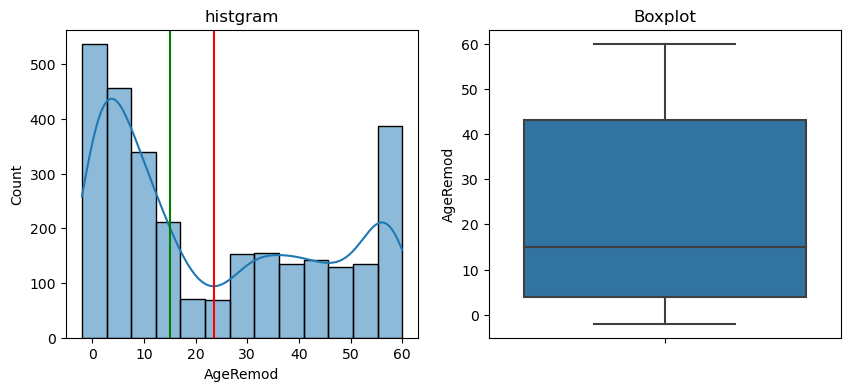

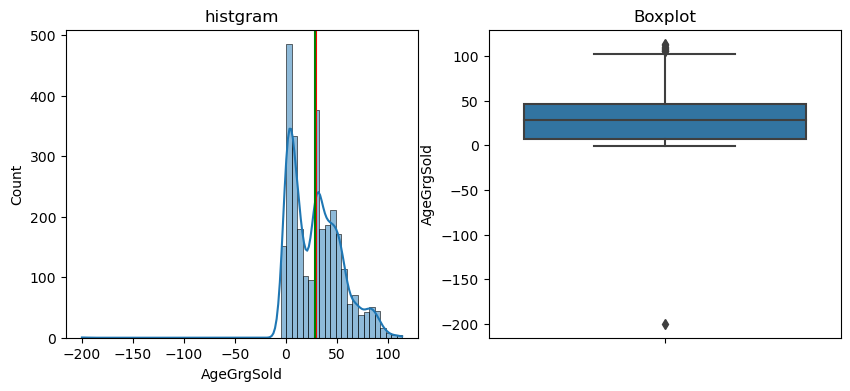

In [27]:
for col in num_cols:
    two_plots_num_column(col)

### deal with outliers and skewness

### 1-outliers

GrLivArea column

In [28]:
# Create a boolean mask to identify the values that are greater than 3000
mask = df['GrLivArea'] > 3000

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'GrLivArea'] = df['GrLivArea'].mean()

the skewness value of GrLivArea column = 0.65


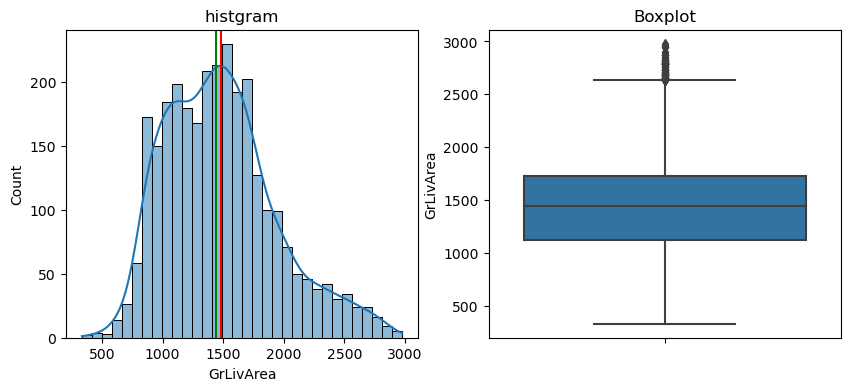

In [29]:
two_plots_num_column('GrLivArea')

TotalSF column

In [30]:
# Create a boolean mask to identify the values that are greater than 3000
mask = df['TotalSF'] > 5500

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'TotalSF'] = df['TotalSF'].mean()

the skewness value of TotalSF column = 0.58


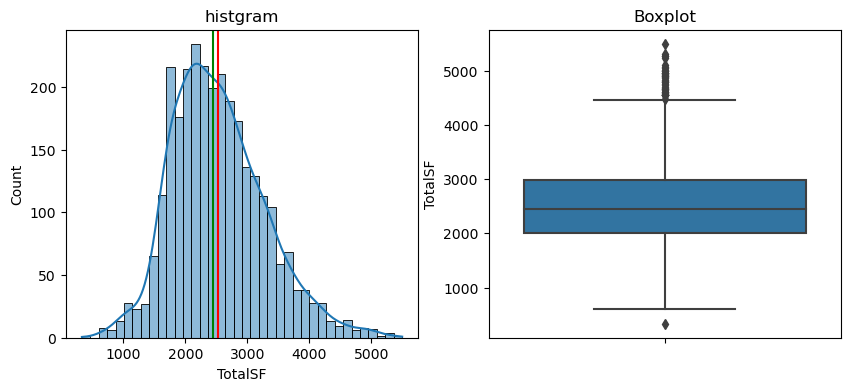

In [31]:
two_plots_num_column('TotalSF')

LotFrontage column

In [32]:
# train data
# Create a boolean mask to identify the values that are greater than 150
mask = df['LotFrontage'] > 150

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'LotFrontage'] = df['LotFrontage'].mean()

the skewness value of LotFrontage column = 0.24


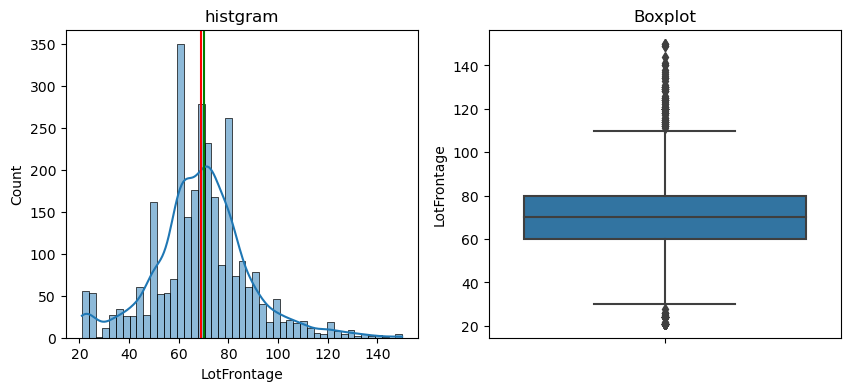

In [33]:
two_plots_num_column('LotFrontage')

LotArea column

In [34]:
# Create a boolean mask to identify the values that are greater than 20000
mask = df['LotArea'] > 20000

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'LotArea'] = df['LotArea'].mean()

the skewness value of LotArea column = 0.09


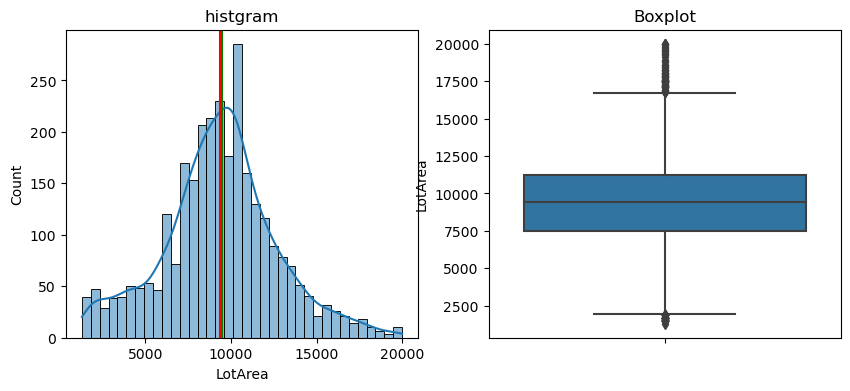

In [35]:
two_plots_num_column('LotArea')

GarageArea column

In [36]:
# Create a boolean mask to identify the values that are greater than 1100
mask = df['GarageArea'] > 1100

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'GarageArea'] = df['GarageArea'].mean()

the skewness value of GarageArea column = -0.01


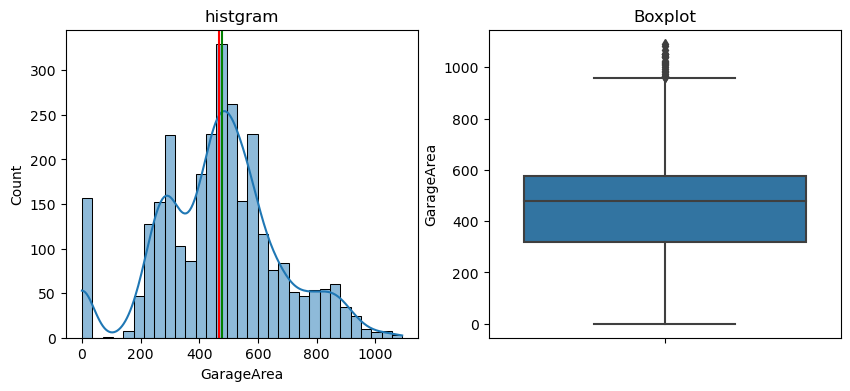

In [37]:
two_plots_num_column('GarageArea')

WoodDeckSF column

In [38]:
# Create a boolean mask to identify the values that are greater than 400
mask = df['WoodDeckSF'] > 400

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'WoodDeckSF'] = df['WoodDeckSF'].mean()

the skewness value of WoodDeckSF column = 0.95


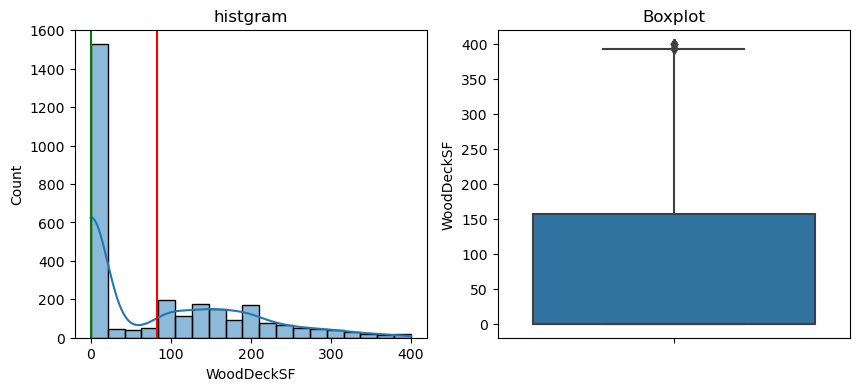

In [39]:
two_plots_num_column('WoodDeckSF')

MasVnrArea column

In [40]:
# Create a boolean mask to identify the values that are greater than 500
mask = df['MasVnrArea'] > 500

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'MasVnrArea'] = df['MasVnrArea'].mean()

the skewness value of MasVnrArea column = 1.55


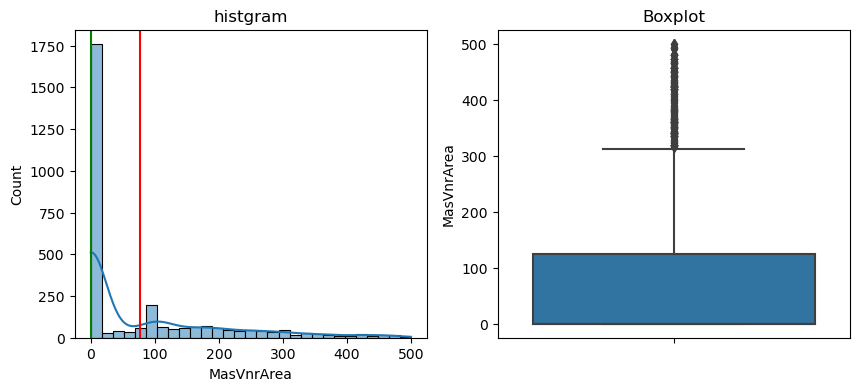

In [41]:
two_plots_num_column('MasVnrArea')

AgeGrgSold column

In [42]:
# Create a boolean mask to identify the values that are lower than 0
mask = df['AgeGrgSold'] < 0

# Replace the values that satisfy the mask with the mean value
df.loc[mask, 'AgeGrgSold'] = df['AgeGrgSold'].mean()

the skewness value of AgeGrgSold column = 0.68


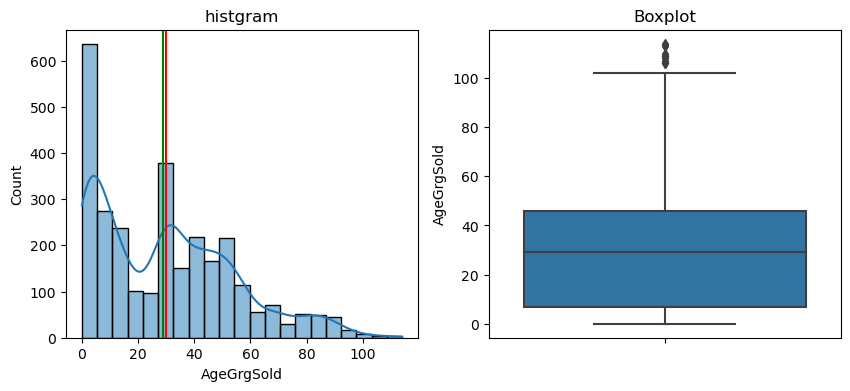

In [43]:
two_plots_num_column('AgeGrgSold')

### 2-skewness

In [44]:
# Calculate the skewness values
skewness_vals = skew(df[num_cols], axis=0)

# Create a DataFrame of skewness values
skewness_df = pd.DataFrame({'Feature': num_cols, 'Skewness': skewness_vals})
skewness_df = skewness_df.sort_values('Skewness', ascending=False)

skewness_df

,Feature,Skewness
6,OpenPorchSF,2.538114
2,MasVnrArea,1.550068
5,WoodDeckSF,0.954408
10,AgeGrgSold,0.675347
3,GrLivArea,0.647292
8,HouseAge,0.597904
7,TotalSF,0.578233
9,AgeRemod,0.449224
0,LotFrontage,0.236549
1,LotArea,0.089803


In [45]:
skewness_df = skewness_df[skewness_df['Skewness'] >= 0.59]

skewed_features = skewness_df['Feature'].values
limit = 0.3
for feat in skewed_features:
    df[feat] = boxcox1p(df[feat], limit)

the skewness value of MasVnrArea column = 0.66


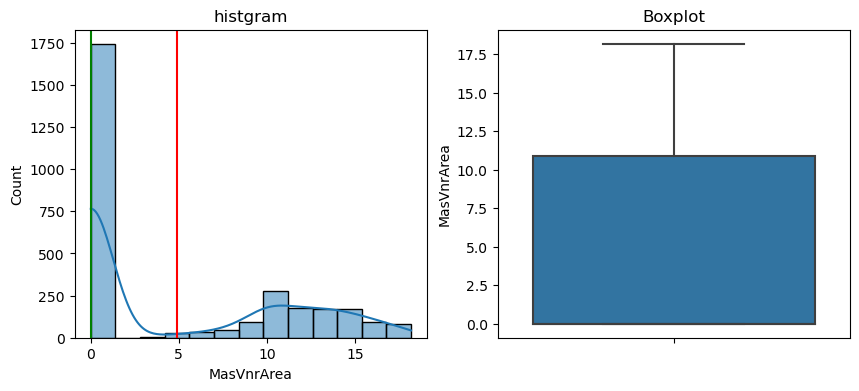

In [46]:
#check
two_plots_num_column('MasVnrArea')

### 4.2. explore descrete columns

In [47]:
print(f'number of descrete columns: {len(descrete_cols)}')
print(f'descrete columns: {descrete_cols}')

number of descrete columns: 13
descrete columns: ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea', 'MoSold']


In [48]:
def two_plots_descrete_column(feature):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.title(f'{feature} Histogram')
    sns.countplot(data=train , x=feature ,palette="Set2")
    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    plt.title(f'{feature} vs Price')
    sns.boxplot(x=train[feature], y=train["SalePrice"],palette="Set2")
    plt.xticks(rotation=90)
    
    plt.tight_layout()

OverallQual column

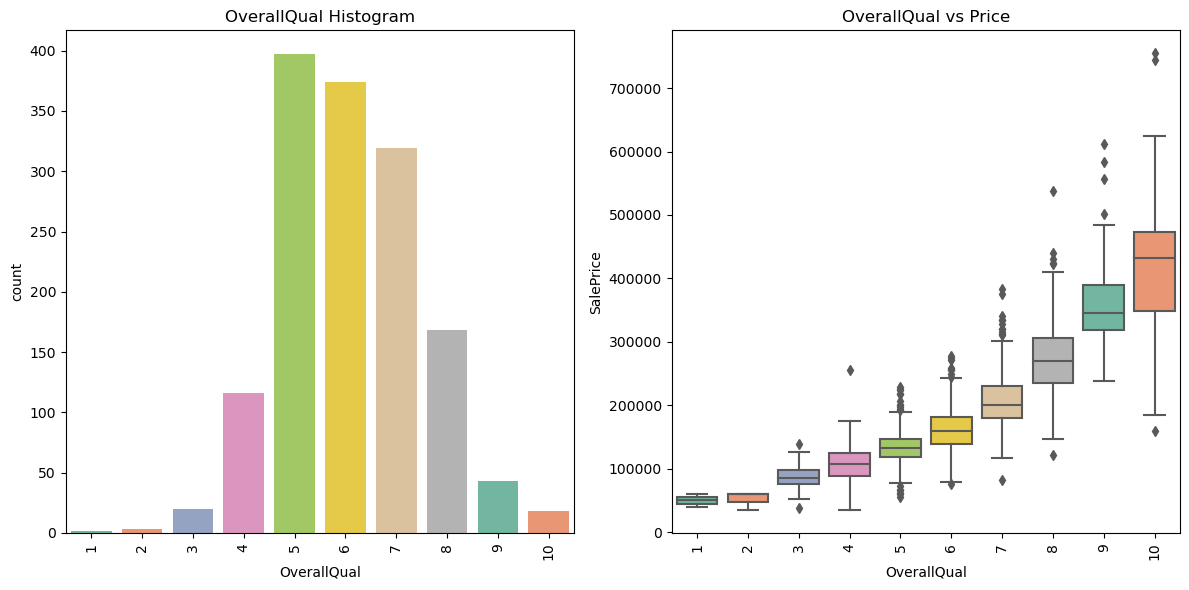

In [49]:
two_plots_descrete_column('OverallQual')

* People pay more for better quality? Nothing new here. Let's move on.

GarageCars

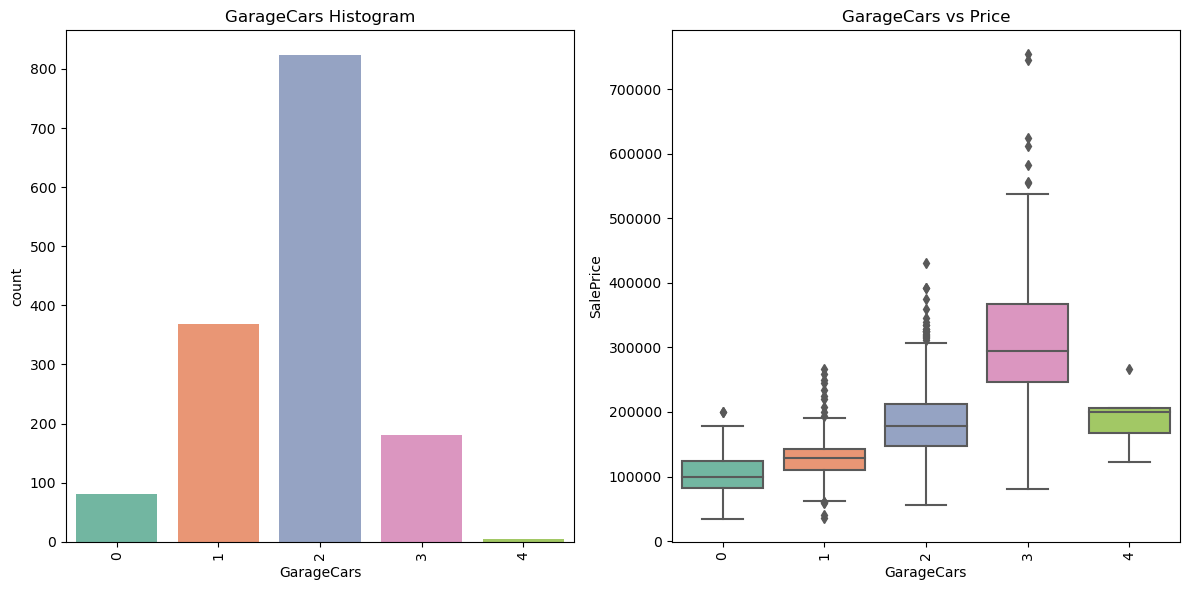

In [50]:
two_plots_descrete_column('GarageCars')

* 4-car garages result in less Sale Price? That doesn't make much sense. it must have outliers.

PoolArea column

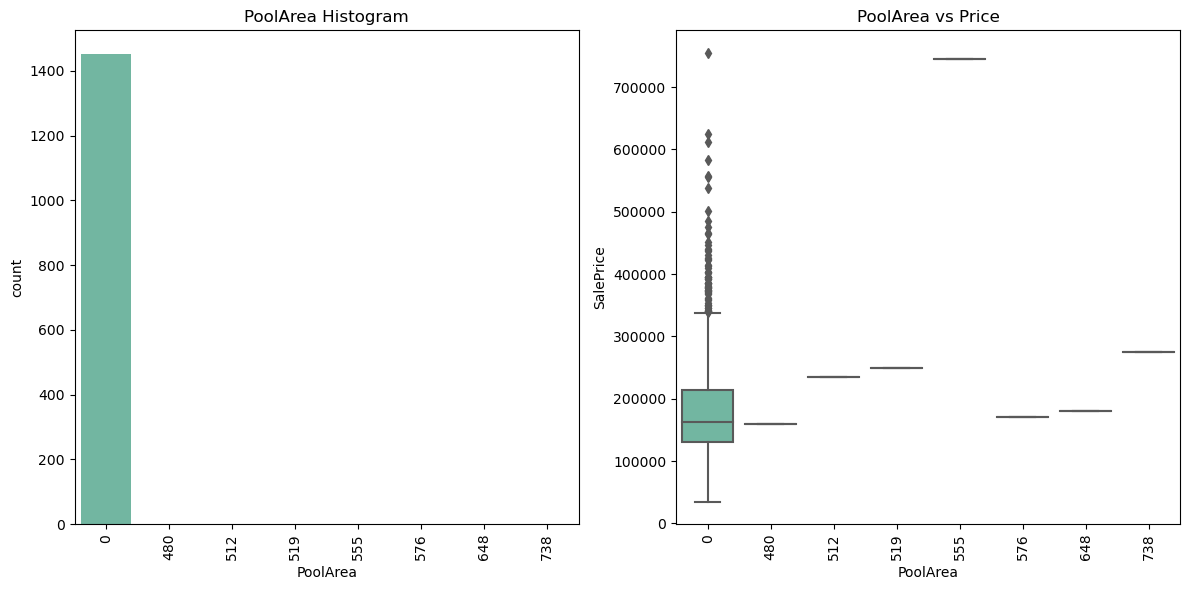

In [51]:
two_plots_descrete_column('PoolArea')

In [52]:
df['PoolArea'].describe([0.8,0.9,0.95])

count    2917.000000
mean        2.253342
std        35.676126
min         0.000000
50%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
max       800.000000
Name: PoolArea, dtype: float64

* above 95% of its values equal zero . we will drop it

In [53]:
df.drop(columns='PoolArea' , inplace=True)

TotRmsAbvGrd column

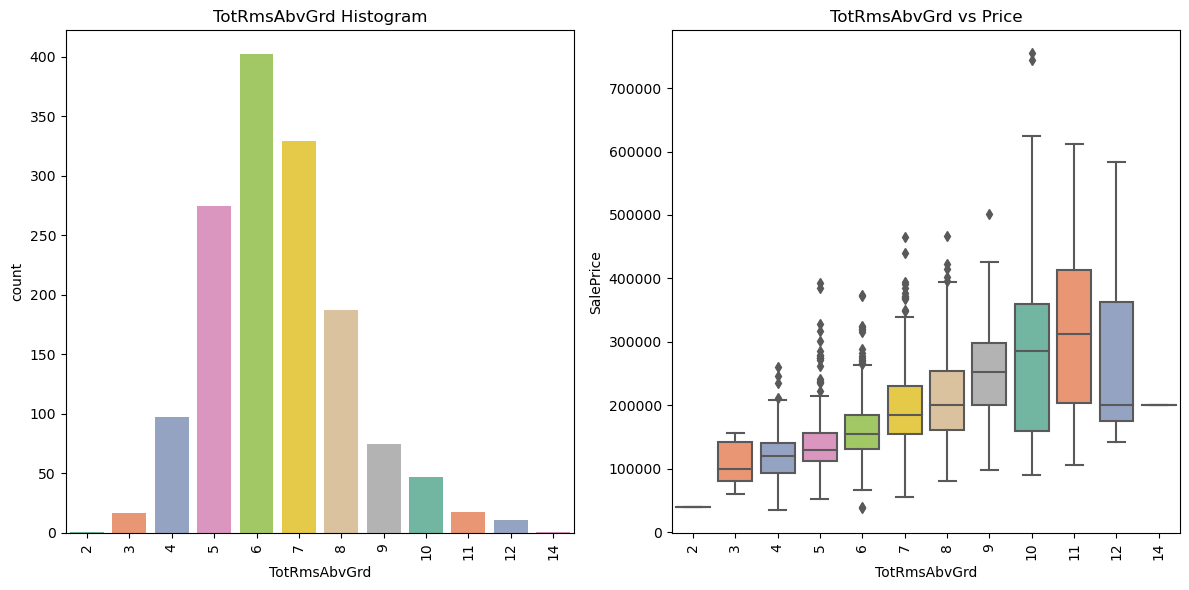

In [54]:
two_plots_descrete_column('TotRmsAbvGrd')

* most houses have 6 rooms above grade (does not include bathrooms), It looks like an outlier

MoSold column

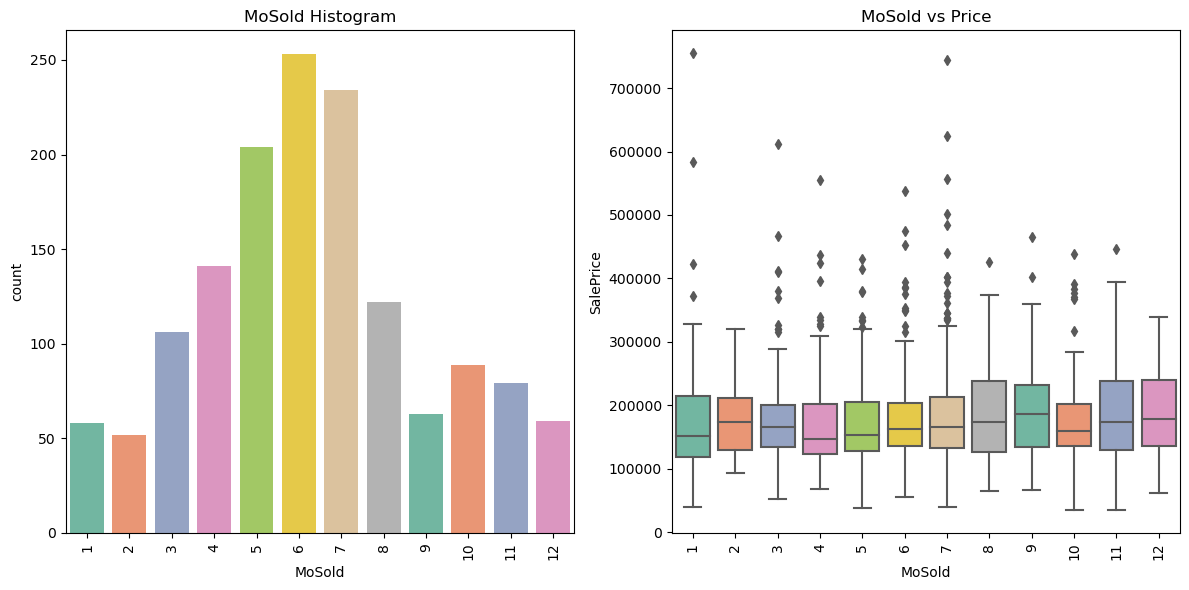

In [55]:
two_plots_descrete_column('MoSold')

* June month have the most sold house . The price of houses is almost constant during the year.

### 4.3. explore categorical data

In [56]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']
cat_but_car = [col for col in df.columns if df[col].nunique() > 20 and df[col].dtypes == 'O']

# categorical columns
cat_cols = [col for col in cat_cols if col not in cat_but_car]

In [57]:
df[cat_cols].head()

,MSZoning,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Reg,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,Nofireplaces,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Reg,Lvl,FR2,Gtl,Feedr,Norm,1Fam,1Story,Gable,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,IR1,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,IR1,Lvl,Corner,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,IR1,Lvl,FR2,Gtl,Norm,Norm,1Fam,2Story,Gable,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [58]:
# label encoder
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in ['int64', 'float64'] and df[col].nunique() <= 2]

for col in binary_cols:
    df = label_encoder(df, col)


In [59]:
# one hot encoder
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
ohe_cols = [col for col in df.columns if 25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)

In [60]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.01).any(axis=None)]

df.drop(useless_cols, axis=1, inplace=True)

print(useless_cols)

['MSZoning_RH', 'LotShape_IR3', 'LotConfig_FR3', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_NPkVill', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_RRAe', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_1.5Unf', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'OverallQual_2', 'OverallCond_2', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran', 'RoofMatl_Metal', 'RoofMatl_Roll', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'ExterCond_Po', 'Foundation_Stone', 'Foundation_Wood', 'BsmtCond_Po', 'Heating_GasW', 'Heating_Grav', 'Heating_OthW', 'Heating_Wall', 'HeatingQC_Po', 'Ele

In [61]:
df.shape

(2917, 197)

# 5. bivariate analysis

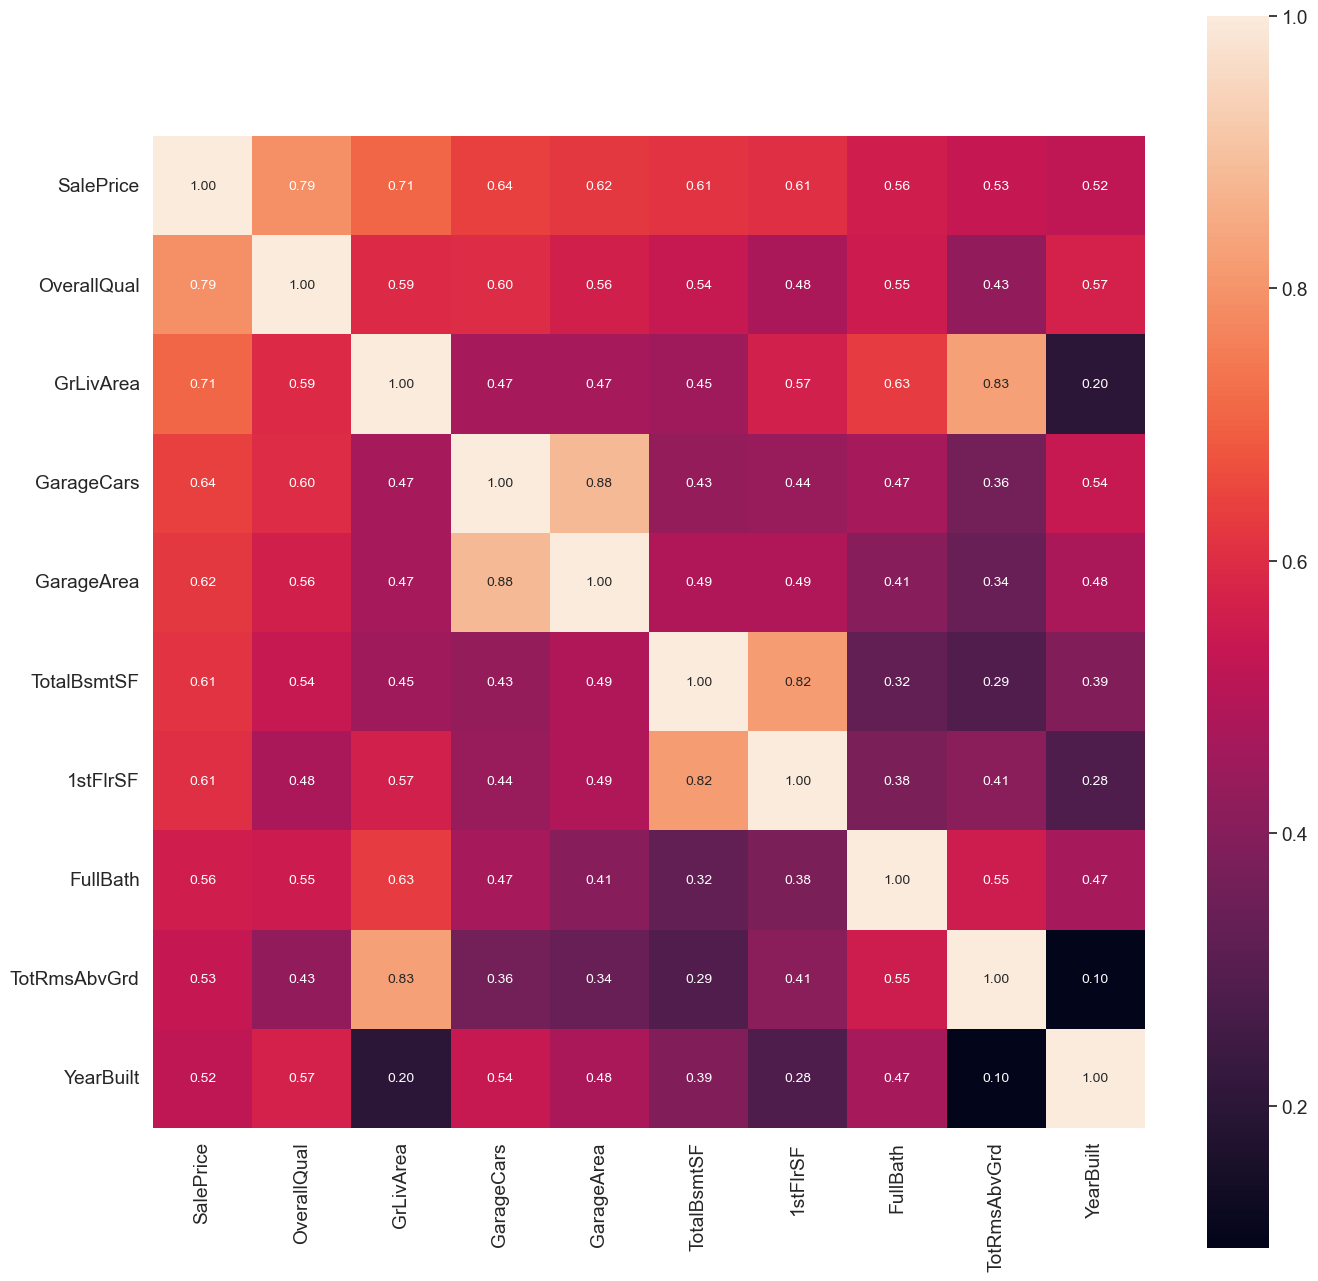

In [62]:
plt.figure(figsize=(16,16))
corrmat = train.corr()
columns = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
correlation_matrix = np.corrcoef(train[columns].values.T)
sns.set(font_scale=1.25)
heat_map = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()


# 6. modeling

In [63]:
train_processed = df[:ntrain]
test_processed = df[ntrain:]
print("Train_processed",train_processed.shape)
print("Test_processed",test_processed.shape)

Train_processed (1460, 197)
Test_processed (1457, 197)


In [64]:
X = train_processed
y = train["SalePrice"]

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=45)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)

X_train (1095, 197)
y_train (1095,)
X_test (365, 197)
y_test (365,)


### Hyperparameter Optimization with RandomSearchCV¶

In [66]:
def cross_val(model):
    pred = cross_val_score(model, X, y, cv=5)
    return pred.mean()


def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

#### 1-Random Forest Regressor


In [67]:
#Random Forest Regressor
rf = RandomForestRegressor(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=rf_random_params,
                               n_iter=100,  
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=17),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': array([ 7, 18, 47, 32, 38, 41, 41, 46, 38, 37]),
                                        'max_features': [3, 5, 7, 'auto',
                                                         'sqrt'],
                                        'min_samples_split': array([ 2, 31, 23, 45,  8, 25, 32,  5, 25, 33, 10, 21, 17, 34, 25, 43, 23,
       31, 45,  9]),
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, verbose=True)

In [68]:
print(rf_random.best_params_)

rf_random_final = rf.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

{'n_estimators': 488, 'min_samples_split': 9, 'max_features': 'auto', 'max_depth': 38}


In [69]:
preds_rf = rf_random_final.predict(X_test)
mae_rf = mean_absolute_error(y_test, preds_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, preds_rf))
cv_rf = cross_val(rf_random_final)

print(mae_rf)
print(rmse_rf)
print(cv_rf)

9055.199302748959
14749.858317572212
0.8463084407237675


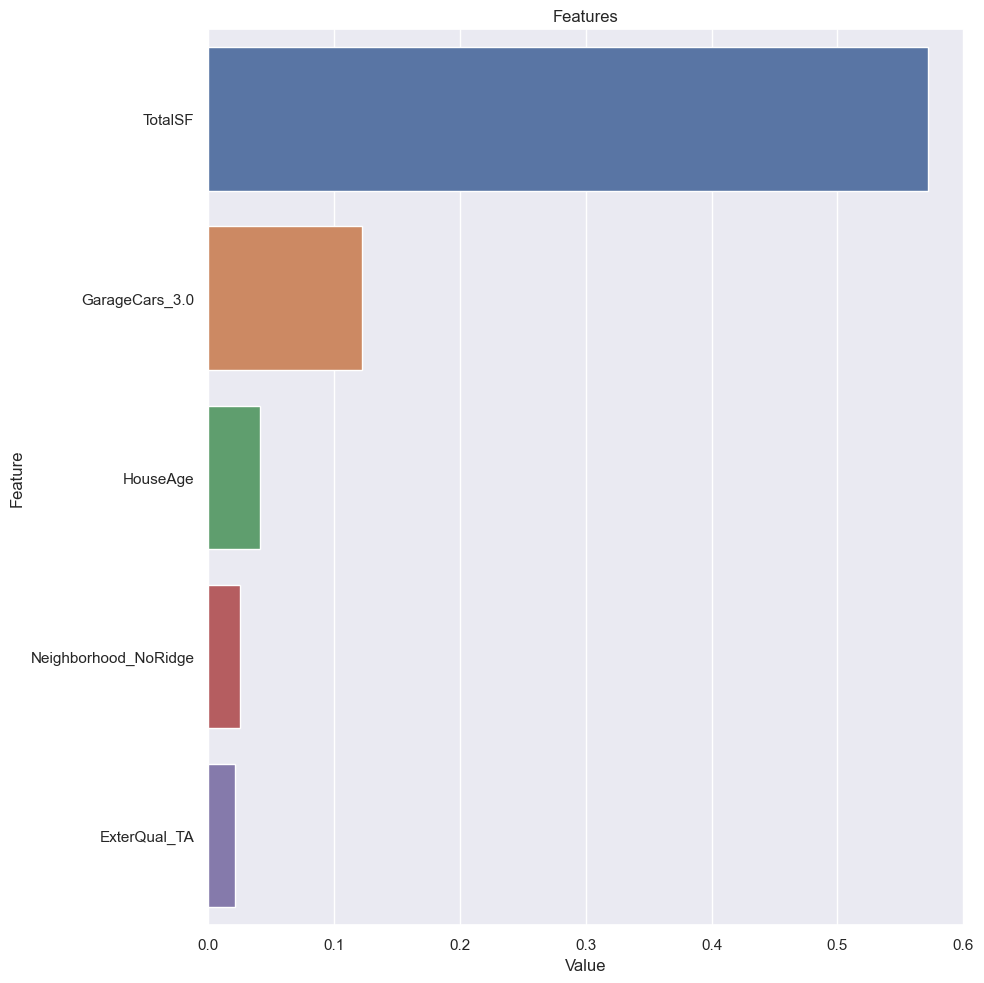

In [70]:
plot_importance(rf_random_final, X_train, num=5)

#### 2-XGBoost Regressor

In [71]:
xgb = XGBRegressor(random_state=17)

xgb_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "subsample": [0.7, 1]}

xgb_random = RandomizedSearchCV(estimator=xgb,
                               param_distributions=xgb_params, 
                               verbose=True,n_iter=100,
                               n_jobs =-1)

xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_delta_step=None, max_depth=None,
                                          max_le

In [72]:
print(xgb_random.best_params_)

xgb_random_final = xgb.set_params(**xgb_random.best_params_, random_state=17).fit(X, y)

{'subsample': 0.7, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1}


In [73]:
preds_xgb = xgb_random_final.predict(X_test)
mae_xgb = mean_absolute_error(y_test, preds_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
cv_xgb = cross_val(xgb_random_final)

print(mae_xgb)
print(rmse_xgb)
print(cv_xgb)

985.709792380137
1292.0919056510263
0.8776547959583908


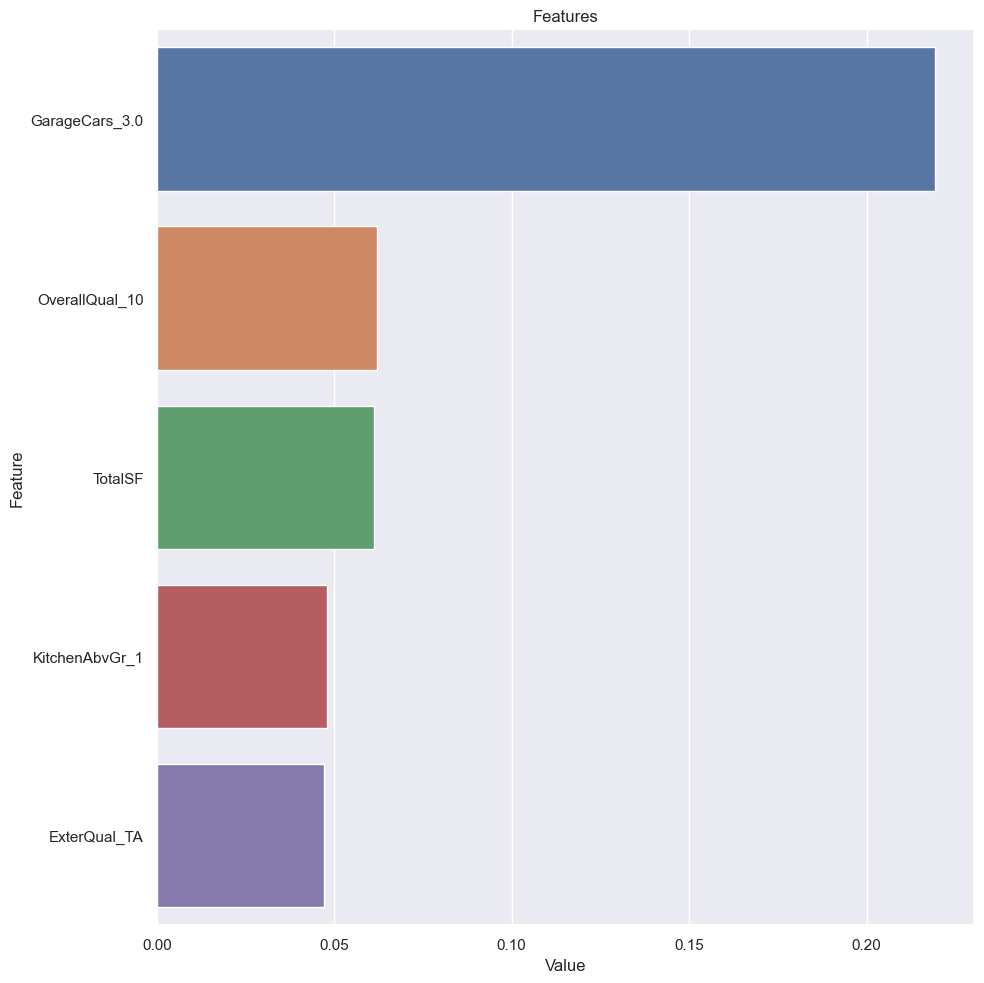

In [74]:
plot_importance(xgb_random_final, X_train, num=5)

#### 3-CatBoost Regressor

In [75]:
# CatBoost Regressor
cb = CatBoostRegressor(loss_function='RMSE', logging_level='Silent')
cb_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
cb_random = GridSearchCV(estimator=cb,param_grid=cb_params, n_jobs=-1)

cb_random.fit(X_train, y_train)

GridSearchCV(estimator=<catboost.core.CatBoostRegressor object at 0x000001FEE02AB670>,
             n_jobs=-1,
             param_grid={'depth': [3, 6], 'iterations': [200, 500],
                         'learning_rate': [0.01, 0.1]})

In [76]:
print(cb_random.best_params_)

cb_random_final = cb.set_params(**cb_random.best_params_, random_state=17).fit(X, y)

{'depth': 3, 'iterations': 500, 'learning_rate': 0.1}


In [78]:
preds_cb= cb_random_final.predict(X_test)
mae_cb = mean_absolute_error(y_test, preds_cb)
rmse_cb = np.sqrt(mean_squared_error(y_test, preds_cb))
cv_cb = cross_val(cb_random_final)

print(mae_cb)
print(rmse_cb)
print(cv_cb)

9857.362792541657
12971.392872590653
0.8952096602325337


In [ ]:
plot_importance(cb_random_final, X_train, num=5)

# 7. Evaluate

In [83]:
model_performances = pd.DataFrame({
    "Model" : ["RandomForest","XGBoost", "CatBoost"],
    "CV(5)" : [str(cv_rf)[0:5],str(cv_xgb)[0:5], str(cv_cb)[0:5]],
    "MAE" : [str(mae_rf)[0:5],str(mae_xgb)[0:5], str(mae_cb)[0:5]],
    "RMSE" : [str(rmse_rf)[0:5],str(rmse_xgb)[0:5], str(rmse_cb)[0:5]]
})

print("Sorted by :CV")
print(model_performances.sort_values(by="CV(5)"))

Sorted by :CV
          Model  CV(5)    MAE   RMSE
0  RandomForest  0.846  9055.  14749
1       XGBoost  0.877  985.7  1292.
2      CatBoost  0.895  9857.  12971


In [85]:
predict1 = rf_random_final.predict(test_processed)
predict2 = xgb_random_final.predict(test_processed)
predict3 = cb_random_final.predict(test_processed)
predict_y = ( predict1*0.30 + predict2 * 0.30 + predict3 * 0.40)

# 8. Submission

In [ ]:
predictions = pd.DataFrame({'Id': test_ID,
                           'SalePrice': predict_y})
predictions.to_csv(, index=False)